# Hierarchical and low-rank techniques

Some processes are represented by dense matrices that have structured representations.  The most common technique is to approximate blocks using a truncated SVD $U S V^T$.

Inverses of differential operators sometimes have this property.

<IPython.core.display.Javascript object>


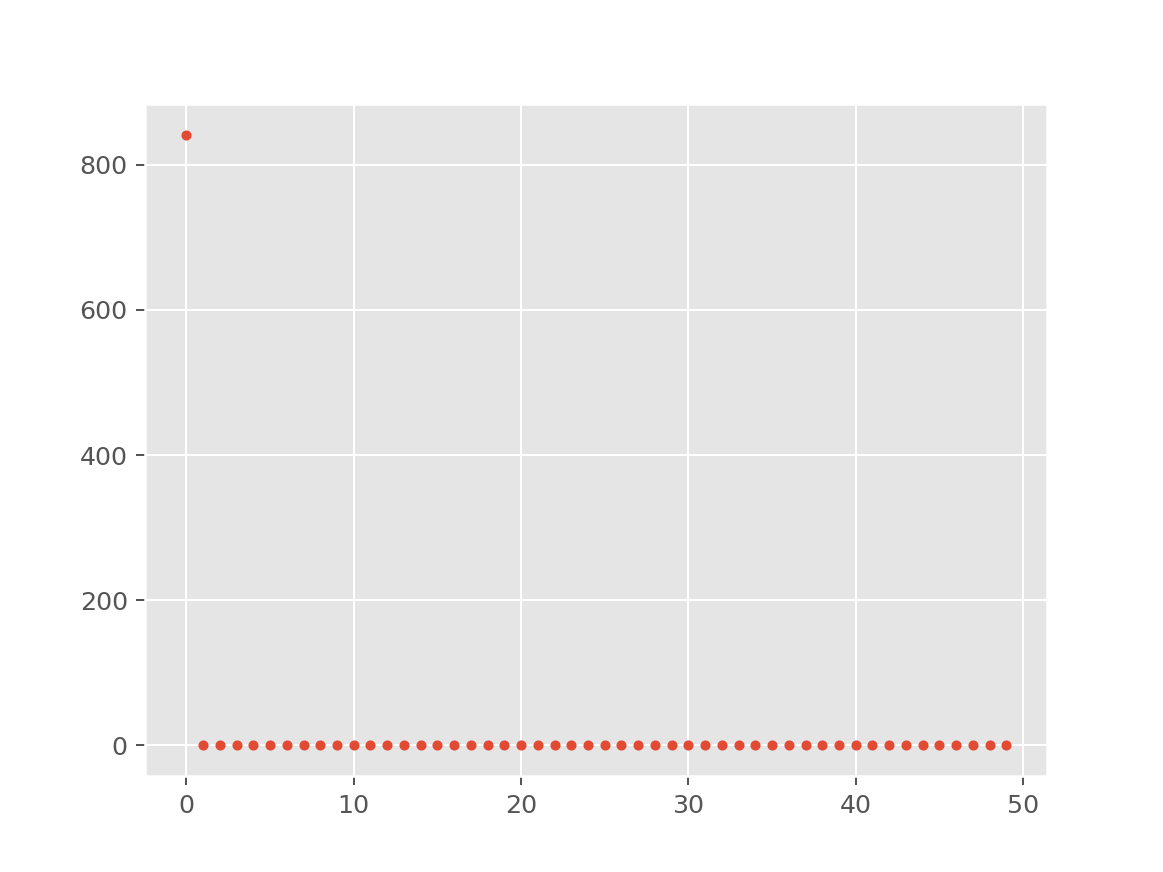

In [1]:
%matplotlib notebook
import numpy

m = 101
A = numpy.eye(m) - .5*numpy.eye(m,k=1) - .5*numpy.eye(m,k=-1)
Ainv = numpy.linalg.inv(A)

B = Ainv[:m//2,m//2+1:]
U, S, V = numpy.linalg.svd(B)

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(S, '.')

<IPython.core.display.Javascript object>


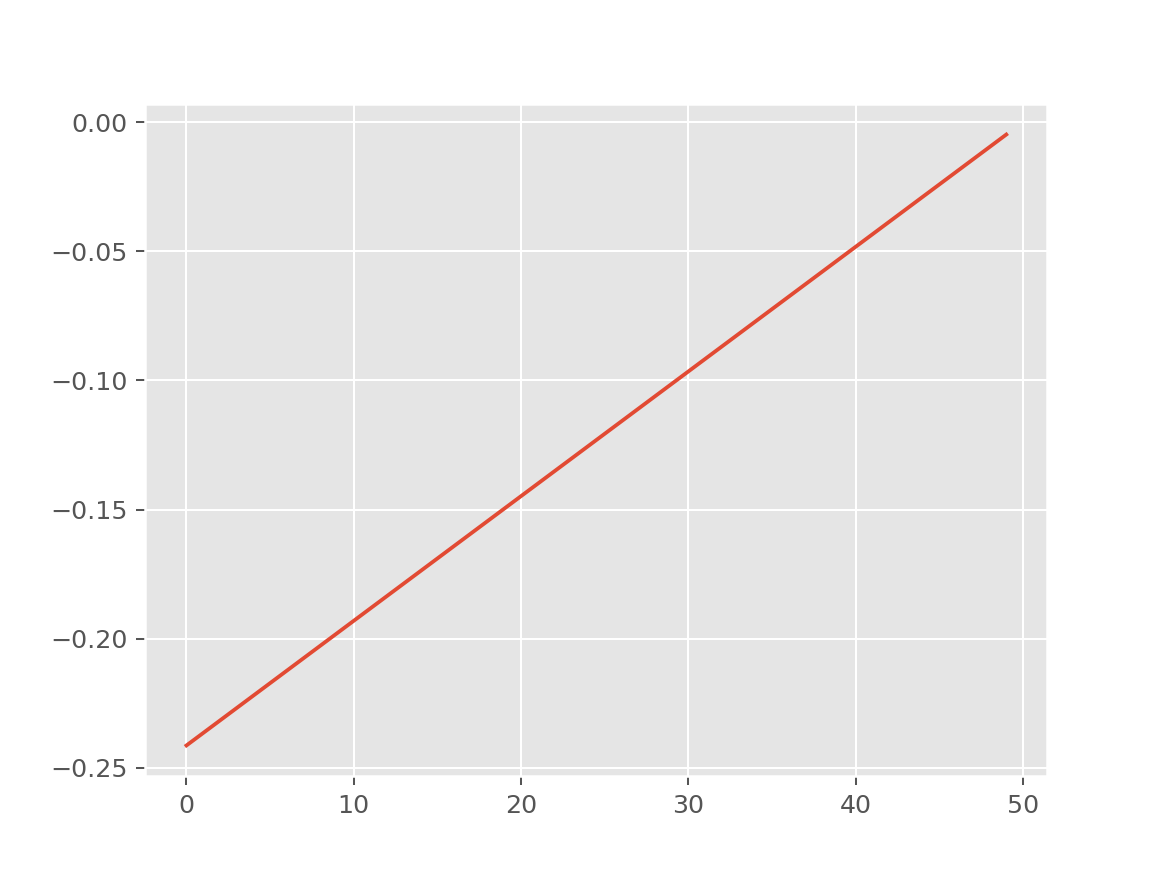

In [2]:
pyplot.figure()
pyplot.plot(V.T[:,0])

## Particle interactions

The gravitational (or electrostatic) force between particles is proportional to $1/|r|^2$ where $r$ is the distance between them.  The direction of this force is in the direction $r$ with magnitude equal to the product of the masses (or charges).  Let's consider two separated groups of particles.

<IPython.core.display.Javascript object>


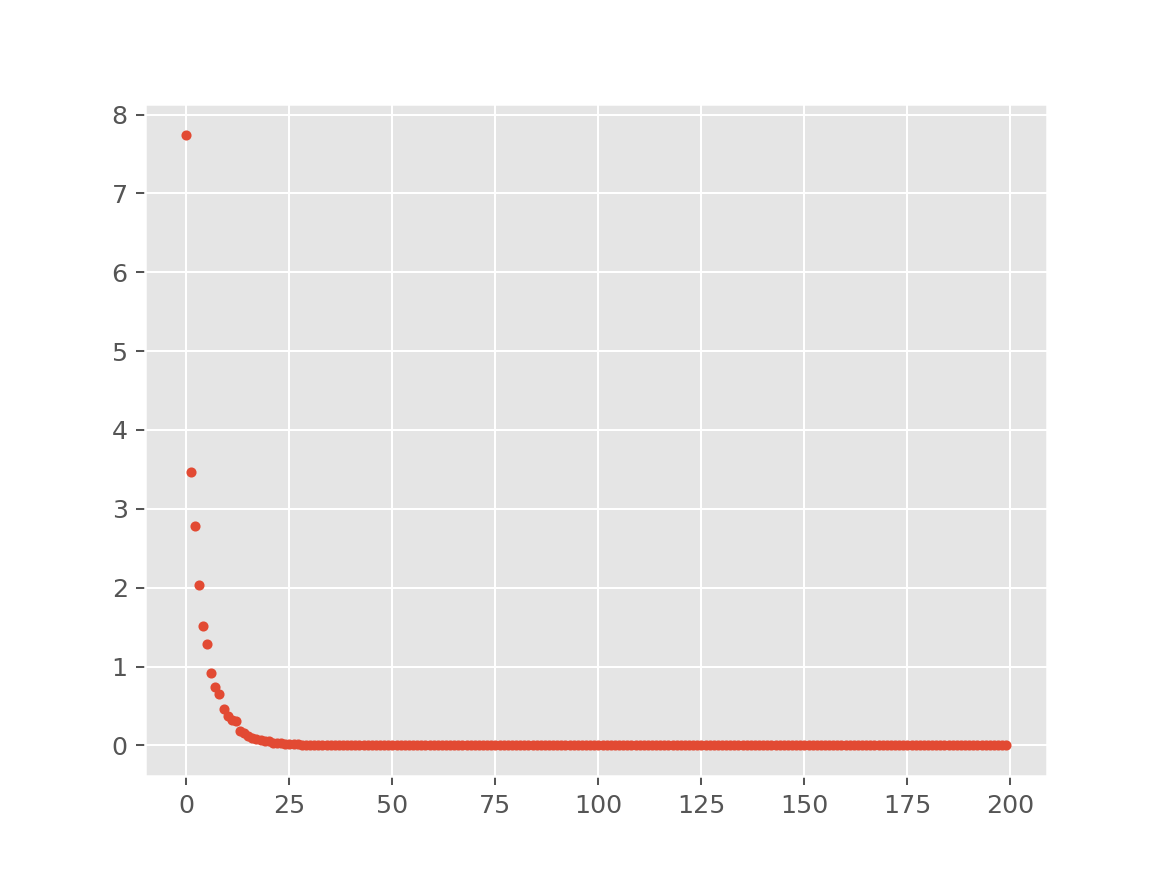

In [3]:
m, n = 100, 200
x = numpy.random.randn(m,3)
y = numpy.random.randn(n,3)
y[:,0] += 5

A = numpy.zeros((3*m,n))
for i in range(m):
    r = y.T - numpy.outer(x[i,:], numpy.ones(n))
    A[3*i:3*i+3, :] = r / numpy.linalg.norm(r, axis=0)**3

U, S, V = numpy.linalg.svd(A, full_matrices=False)

pyplot.figure()
pyplot.plot(S, '.')